In [3]:
import numpy as np
import torch
from torch.utils import data

def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 生成特征矩阵
    y = torch.matmul(X, w) + b  # 真实值
    y += torch.normal(0, 0.01, y.shape) # 增加噪声
    return X, y.reshape((-1, 1)) # reshape保证y是二维，自动推导维度0的尺寸

### 生成数据集

In [4]:
true_w = torch.tensor([2, -3.4]) # 真实的权值值
true_b = 4.2 # 真实的偏置的值
features, labels = synthetic_data(true_w, true_b, 1000) # 获得数据集
features # 1000 x 2

tensor([[-0.1694, -2.0079],
        [-0.2227, -0.6855],
        [ 0.9193, -0.0735],
        ...,
        [ 0.7175, -1.0777],
        [ 0.5484, -0.1222],
        [ 0.8781,  1.0120]])

### 读取数据集

In [5]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [6]:
next(iter(data_iter))

[tensor([[-0.7855,  0.5108],
         [-0.2804, -1.6360],
         [-0.2227, -0.6855],
         [-1.1871, -1.6714],
         [-0.3960,  0.1546],
         [-1.2611, -0.5265],
         [ 0.0489, -0.3879],
         [-0.4074,  0.7234],
         [-1.0118,  0.2661],
         [-0.5243,  0.5970]]),
 tensor([[0.9010],
         [9.1935],
         [6.0616],
         [7.4999],
         [2.8803],
         [3.4677],
         [5.6018],
         [0.9226],
         [1.2755],
         [1.1188]])]

### 定义模型
我们只需关注使用哪些层来构造模型，而不必关注层的实现细节。比如说模型参数的创建以及初始化都是根据自动完成的

In [7]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

### 初始化模型参数

In [8]:
# 方法_ ：会修改对象的值
# 我们可以通过_结尾的方法将参数替换，从而初始化参数。
net[0].weight.data.normal_(0, 0.01) # 正态分布
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

In [9]:
loss = nn.MSELoss(reduction='none') # 默认情况下，它返回所有样本损失的平均值。

### 定义优化算法 SGD

In [10]:
trainer = torch.optim.SGD(net.parameters(), lr=0.003)

### 训练
通过深度学习框架的高级API来实现我们的模型只需要相对较少的代码。 我们不必单独分配参数、不必从头定义我们的损失函数，也不必手动实现小批量随机梯度下降。 当我们需要更复杂的模型时，高级API的优势将大大增加。 

In [11]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y) #计算这一批数据的损失
        trainer.zero_grad() # 将参数梯度清零，避免累计梯度的情况
        l.sum().backward() # 反向传播计算梯度，有了梯度才能知道参数要如何更新才能使得loss最小
        trainer.step() # 更新参数
    
    # 一个epoch后，查看在整个训练集上的平均损失
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l.mean():f}')

epoch 1, loss 0.000203
epoch 2, loss 0.000098
epoch 3, loss 0.000097


In [12]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0004,  0.0003])
b的估计误差： tensor([-0.0002])


In [13]:
w, b # 很接近真实值了

(tensor([[ 2.0004, -3.4003]]), tensor([4.2002]))

## 练习题

1.如果我们用nn.MSELoss(reduction='sum')替换 nn.MSELoss()”为了使代码的行为相同，需要怎么更改学习速率？为什么？

应该把学习率除batch_size。因为如果损失函数不是求均值，而是只求和，然后进行反向传播，那么相当于求的梯度比原来扩大了batch_size倍，代入梯度下降算法更新参数的公式，便发现这个变化可以相当于是学习率大小大了batch_size倍。因此如果想使l.sum().backward()得到与l.mean().backward()同样的更新效果，需要把学习率降低batch_size倍

由此可见，损失函数使用l.sum()或者l.mean()其实差不多，无非是对于等效的参数更新，两者的学习率刚好差batch_size倍，调参能够调出一样的效果

l.mean().backward() lr=0.03
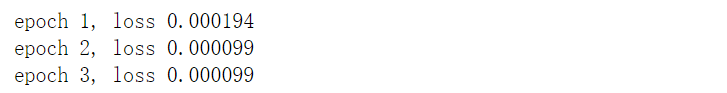
l.sum().backward()  lr=0.003
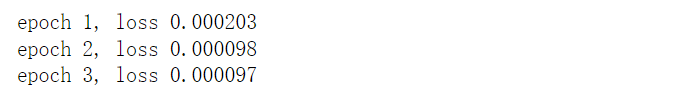